n_samples = 300
state_dim = 256
some samples (viewed as (16, 16)):


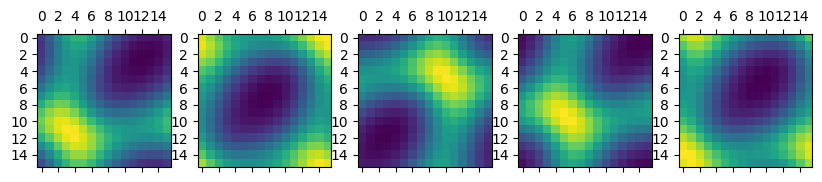

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

# load training data
Y = torch.tensor( np.load("ks2d_long.npy") )
state_dim_orig = Y.shape[1:]
Y = Y.view(-1, Y.shape[1]*Y.shape[2])
Y_train = Y[900:1200,:]

# number of samples and the state dimension 
n_samples = Y_train.shape[0]
state_dim = Y_train.shape[1]
print(f"n_samples = {n_samples}")
print(f"state_dim = {state_dim}")

# plots a few samples
print(f"some samples (viewed as {tuple(state_dim_orig)}):")
n_plots = 5 
fig, ax = plt.subplots(1,n_plots,figsize=(10,2))
for j in range(n_plots):
    ax[j].matshow(Y_train[int(n_samples*(j/n_plots)),:].view(*state_dim_orig).numpy())
plt.show()

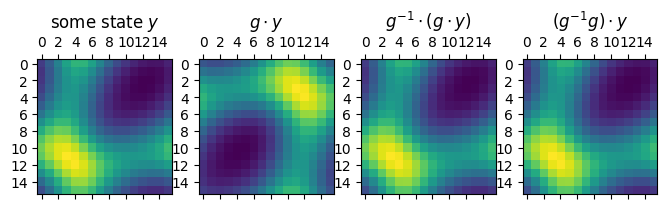

In [499]:
# defines the group G = Z_4 x Z_4
G = [ (g0, g1) for g0 in range(4) for g1 in range(4) ]

# defines the group operation
def op(g, h):
    return ( (g[0] + h[0]) % 4, (g[1] + h[1]) % 4 )

# returns the inverse of a group element g
def inverse(g):
    return ( (-g[0]) % 4, (-g[1]) % 4)

# defines a group action of a group element g=(g0,g1)  on a state y
def act_on_state(g, y):
    y_shape = y.shape
    y = y.view(-1, *state_dim_orig)
    y = torch.roll(y, -g[0]*round(state_dim_orig[0]/4), -2)
    y = torch.roll(y, -g[1]*round(state_dim_orig[1]/4), -1)
    y = y.view(*y_shape)
    return y

# plots an original state and its transformed version(s)
fig, ax = plt.subplots(1, 4, figsize=(8,2))
g = (2,2)
ax[0].matshow( Y_train[0,:].view(*state_dim_orig) )
ax[1].matshow( act_on_state(g, Y_train[0,:]).view(*state_dim_orig) )
ax[2].matshow( act_on_state(inverse(g), act_on_state(g, Y_train[0,:])).view(*state_dim_orig) )
ax[3].matshow( act_on_state( op(inverse(g), g), Y_train[0,:]).view(*state_dim_orig) )
ax[0].set_title("some state $y$")
ax[1].set_title("$g \cdot y$")
ax[2].set_title("$g^{-1} \cdot (g \cdot y)$")
ax[3].set_title("$(g^{-1} g) \cdot y$")
plt.show()

In [525]:
from functools import partial
from random import choice

# defines the irreducible representations and their degrees for this particular group
Rho = lambda h, g: torch.exp(-2j*torch.pi*( torch.tensor( g[0]*h[0]/4 + g[1]*h[1]/4) ) ).view(1,1)
G_hat = [ partial(Rho, g=g) for g in G ]
d = { rho: 1 for rho in G_hat }

# defines the generalized Fourier transform and its inverse
# it looks a bit complicated, but this is mainly due to the automatic broadcasting going on:
# GFT(u)      returns a dictionary mapping rho -> sum( u(h) * rho(h) )
# iGFT(u_hat) returns a dictionary mapping g -> (1/|G|) * sum( d_rho * tr( rho(g⁻¹) @ u_hat(rho) ) )
def GFT(u):
    u_shape = u.shape
    return { rho: sum( u[h].view(-1,d[rho],d[rho]) * rho(h).view(1,d[rho],d[rho]) for h in G ) for rho in G_hat }

GFT  = lambda u:              { rho:              sum( u[h].view(-1,d[rho],d[rho]) * rho(h).view(1,d[rho],d[rho]) for h in G )                           for rho in G_hat }
iGFT = lambda u_hat, u_shape: { g:   (1/len(G)) * sum( d[rho] * torch.vmap(torch.trace)( rho(inverse(g)) @ u_hat[rho] ).view(u_shape) for rho in G_hat ) for g in G } 

# check if the GFT & inverse GFT work properly:
u = { g: torch.rand(3,3) for g in G }
u_reconstruction = iGFT(GFT(u), (3,3))
g = choice(G)
print(f"random group element: g = {g}\n")
print(f"original input u: u[g] =\n {u[g]}\n")
print(f"reconstruction from GFT: iGFT(GFT(u))[g] =\n {u_reconstruction[g].real}\n")

random group element: g = (2, 3)

original input u: u[g] =
 tensor([[0.3711, 0.9236, 0.3640],
        [0.4699, 0.4334, 0.9204],
        [0.1011, 0.9669, 0.5770]])

reconstruction from GFT: iGFT(GFT(u))[g] =
 tensor([[0.3711, 0.9236, 0.3640],
        [0.4699, 0.4334, 0.9204],
        [0.1011, 0.9669, 0.5770]])



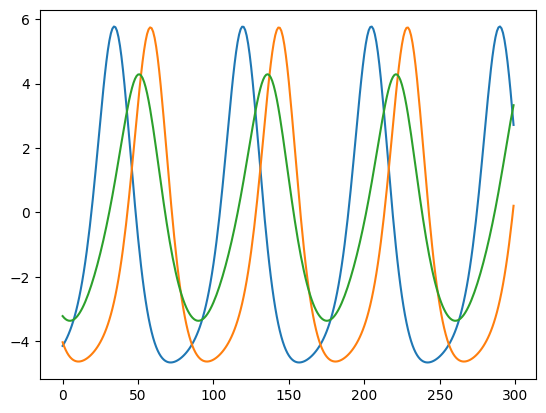

In [503]:
# defines the optimization problem: solves for the optimal EDMD convolution kernel
n_generating_observations = 3
measure_points = torch.randint(low=0,high=state_dim,size=(n_generating_observations,))

# defines a generating observable 
# ( hence: S = {1,2,...n_generating_observables} )
O = [ (s,g) for s in range(n_generating_observations) for g in G ]
chi = lambda y: y[...,measure_points]
# the correponding base observable
psi = lambda y: torch.cat([ chi( act_on_state(g, y) ) for g in G ], dim=-1)
psi_ = lambda y: { g: chi( act_on_state(g, y) ) for g in G } # views psi(y) as a function G -> \C^S instead of a vector \C^O (both are equivalent)

plt.plot( chi( Y_train ) )
# plt.plot( psi( Y_train ) )
plt.show()

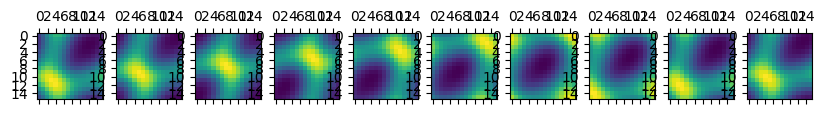

In [496]:
# the EDMD matrix 
K = torch.linalg.lstsq( psi(Y_train[:-1]), psi(Y_train[1:]) ).solution.T
# the reconstruction matrix
B = torch.linalg.lstsq( psi(Y_train), Y_train ).solution.T

# predict a few time steps into the future
T = 100
psi0 = psi(Y_train[0])
Y_pred = torch.empty(T, state_dim)
for t in range(T):
    Y_pred[t,:] = B @ psi0
    psi0 = K @ psi0

# plot results
n_plots = 10
fig, ax = plt.subplots(1, n_plots, figsize=(10,1))
for k in range(n_plots):
    ax[k].matshow( Y_pred[ int(k/n_plots*T) ].view(*state_dim_orig) )

In [524]:
# now with enforced convolutional structure --> we learn a convolution kernel

# define a right group action on O = S x G
def act_on_index(o, g):
    s, h = o
    return ( s, op(h, g) ) 

u_hat = [ GFT(psi_(Y_train[i])) for i in range(n_samples) ]
u_plus_hat = GFT(psi_(Y_train[1:]))
k, v = next(iter(u_hat[0].items()))
v.shape, len(u_hat)

(torch.Size([3, 1, 1]), 300)